In [1]:
import pandas as pd

fish_df = pd.read_csv('fish.csv', sep=';')
fish_df.head()

,Unnamed: 0,Longitude,Latitude,Acantholiparis_opercularis,Acromycter_atlanticus,Acromycter_perturbator,Acropoma_lecorneti,Adelosebastes_latens,Akarotaxis_nudiceps,Albatrossia_pectoralis,...,Zebrasoma_rostratum,Zebrasoma_scopas,Zebrasoma_xanthurum,Zebrias_zebra,Zenarchopterus_buffonis,Zenarchopterus_gilli,Zoramia_fragilis,Zoramia_gilberti,Zoramia_leptacantha,Zoramia_perlita
0,1,-180,90,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,-179,90,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,-178,90,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,-177,90,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,-176,90,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
import networkx as nx

In [3]:
G = nx.Graph()

In [4]:
# Get the list of species columns (all columns except the first, Longitude, and Latitude)
species_cols = fish_df.columns.difference(['Unnamed: 0', 'Longitude', 'Latitude'])


In [5]:
num_rows = fish_df.shape[0]

In [7]:
fish_df_original = fish_df.copy()

In [33]:
fish_df = fish_df[
    (fish_df['Longitude'] > 131) &
    (fish_df['Longitude'] < 194) &
    (fish_df['Latitude'] < 48) &
    (fish_df['Latitude'] > 17)
].reset_index(drop=True)

In [36]:
{
    'max_latitude': fish_df['Latitude'].max(),
    'min_latitude': fish_df['Latitude'].min(),
    'max_longitude': fish_df['Longitude'].max(),
    'min_longitude': fish_df['Longitude'].min(),
}

{'max_latitude': 47,
 'min_latitude': 18,
 'max_longitude': 180,
 'min_longitude': 132}

In [38]:
num_rows_filtered = fish_df.shape[0]
num_rows_filtered

1408

In [39]:

#num_rows = 1000 # Limit to the first 1000 rows for performance reasons
num_rows = fish_df.shape[0]  # Uncomment this line to process all rows

for i in range(num_rows):
    current_row = fish_df.iloc[i]
    current_species = current_row[species_cols]
    # log every 20 rows processed
    if i % 20 == 0:
        print(f"Processing row {i} of {num_rows}")
    if current_species.sum() == 0:
        continue  # skip rows with all zeroes in species columns
    # Iterate through the remaining rows to find connections
    # with shared species
    # This avoids checking pairs that have already been checked (the graph is undirected)
    for j in range(i + 1, num_rows):
        # Get the candidate row
        candidate_row = fish_df.iloc[j]
        candidate_species = candidate_row[species_cols]
        if candidate_species.sum() == 0:
            continue

        intersection = current_species & candidate_species
        intersection_sum = intersection.sum()
        # Find columns where both rows have a 1 (i.e., both have the species)
        if intersection_sum > 0:
            # node name is concatenation of the longitude and latitude
            node_name = f"{current_row['Longitude']}_{current_row['Latitude']}"
            # second node name is constructed similarly
            candidate_node_name = f"{candidate_row['Longitude']}_{candidate_row['Latitude']}"
            # Add an edge between the two nodes
            G.add_edge(node_name, candidate_node_name, weight=intersection_sum)
    if i % 20 == 0:
        print(f"graph size: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Processing row 0 of 1408
graph size: 6275 nodes, 995678 edges


KeyboardInterrupt: 

In [14]:
# Save the graph
nx.write_pajek(G, 'fish_network.net')

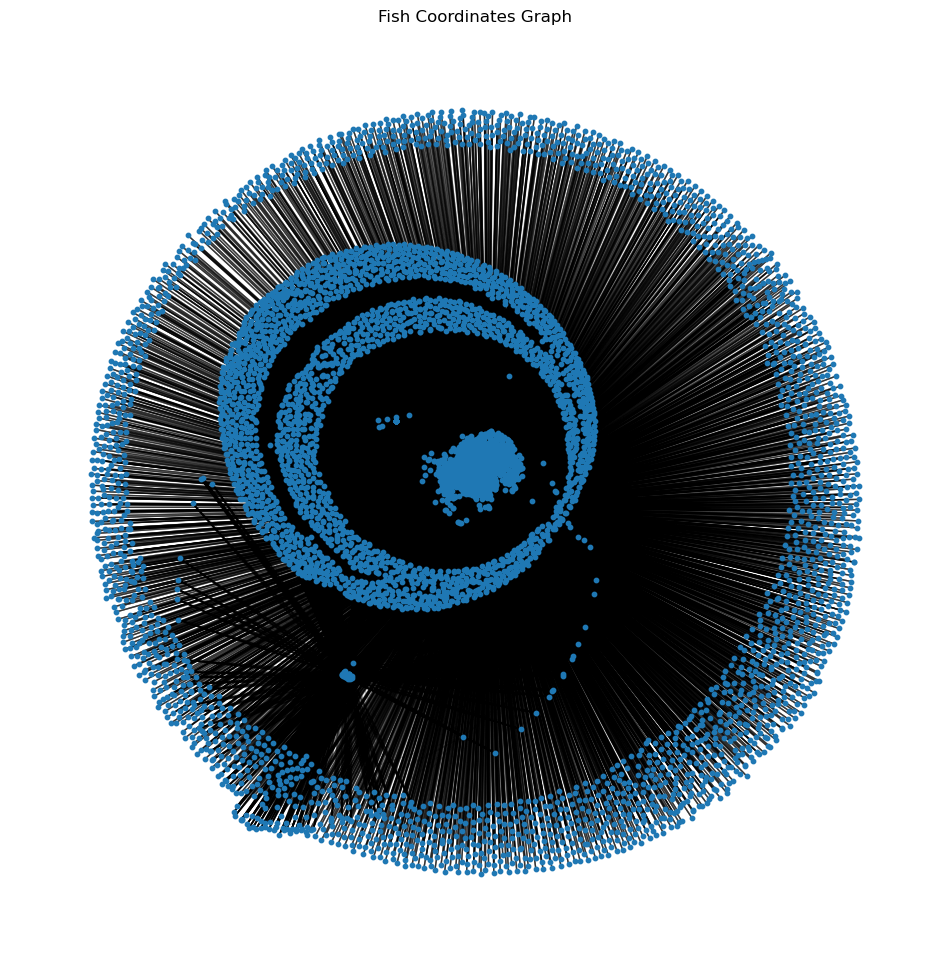

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=10)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Fish Coordinates Graph")
plt.axis('off')
plt.show()

In [15]:
fish_df.to_csv('fish_filtered.csv', index=False)

In [16]:
new_fish_df = nx.read_pajek('fish_network.net')

In [18]:
G2 = new_fish_df

In [20]:
# get top 10 nodes by degree
top_nodes = sorted(G2.degree, key=lambda x: x[1], reverse=True)[:10]

In [21]:
top_nodes

[('140_89', 3202),
 ('144_88', 3202),
 ('145_88', 3202),
 ('146_88', 3202),
 ('147_88', 3202),
 ('148_88', 3202),
 ('149_88', 3202),
 ('-118_88', 2456),
 ('-117_88', 2456),
 ('-116_88', 2456)]

In [22]:
# top 10 edges by weight
top_edges = sorted(G2.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)[:10]
top_edges

[('132_33', '134_33', {'weight': 527.0}),
 ('135_34', '132_33', {'weight': 521.0}),
 ('135_34', '134_33', {'weight': 505.0}),
 ('137_34', '134_33', {'weight': 503.0}),
 ('132_33', '132_32', {'weight': 500.0}),
 ('140_35', '139_34', {'weight': 499.0}),
 ('141_36', '140_35', {'weight': 497.0}),
 ('134_33', '132_32', {'weight': 479.0}),
 ('137_34', '132_33', {'weight': 473.0}),
 ('134_33', '135_33', {'weight': 472.0})]

In [26]:
# count the number of unique names of the nodes
unique_node_names = set(G2.nodes)
unique_node_count = len(unique_node_names)
print(f"Number of unique nodes: {unique_node_count}")

Number of unique nodes: 6275


In [27]:
node_names = list(G2.nodes)
# sort the node names
node_names.sort()
# print the first 10 node names
print("First 10 node names:")
print(node_names[:10])
# print the last 10 node names
print("Last 10 node names:")
print(node_names[-10:])

First 10 node names:
['-100_68', '-100_70', '-100_71', '-100_74', '-100_76', '-100_77', '-100_79', '-100_81', '-100_82', '-100_83']
Last 10 node names:
['9_67', '9_68', '9_69', '9_70', '9_71', '9_72', '9_73', '9_74', '9_82', '9_83']


In [28]:
node_pairs = [tuple(map(int, name.split('_'))) for name in node_names]
node_pairs[:10]  # show the first 10 pairs as a sample

[(-100, 68),
 (-100, 70),
 (-100, 71),
 (-100, 74),
 (-100, 76),
 (-100, 77),
 (-100, 79),
 (-100, 81),
 (-100, 82),
 (-100, 83)]

In [29]:
len(node_pairs)  # total number of node pairs

6275

In [30]:
first_elements = [pair[0] for pair in node_pairs]
min_first = min(first_elements)
max_first = max(first_elements)
print(f"Minimum value: {min_first}, Maximum value: {max_first}")

Minimum value: -180, Maximum value: 180


In [31]:
second_elements = [pair[1] for pair in node_pairs]
min_second = min(second_elements)
max_second = max(second_elements)
print(f"Minimum value: {min_second}, Maximum value: {max_second}")

Minimum value: 18, Maximum value: 89
